In [54]:
#首先 导入工具包

import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
color = sns.color_palette()    #样式设置
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn = ignore_warn    #忽略警告语

from scipy import stats
from scipy.stats import norm, skew    #一些统计函数 
from matplotlib.axes._axes import _log as matplotlib_axes_logger    #仅显示error级别的通知
matplotlib_axes_logger.setLevel('ERROR')

In [7]:
#读取数据集
train = pd.read_csv('/Users/lee/Downloads/数据分析/房价预测项目/train.csv')
test = pd.read_csv('/Users/lee/Downloads/数据分析/房价预测项目/test.csv')

In [8]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [19]:
  #Id列对模型预测没用，先在测试集和训练集中去掉

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id",axis = 1,inplace = True)
test.drop("Id",axis = 1, inplace = True)   

print("\nThe train data size after droping Id feature is : {} " .format(train.shape))  
print("The test data size after droping Id feature is : {} ".format(test.shape))



The train data size after droping Id feature is : (1460, 80) 
The test data size after droping Id feature is : (1459, 79) 


In [22]:
# 合并train test 数据一起处理
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train,test)).reset_index(drop = True)  #拼接两表，把原来的索引列index去掉，重置索引
all_data.drop(['SalePrice'], axis = 1, inplace =True)   #在原对象基础上删除SalePrice列，不创建新对象
print("all data size is : {}".format(all_data.shape))

all data size is : (2919, 79)


In [25]:
all_data_na = (all_data.isnull().sum())/len(all_data)*100   #计算缺失值
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)[:30]  #针对每个含有缺失值（无缺失值为0）的标签进行分类排序
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})   #计算缺失率
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


Text(0.5, 1.0, 'Percent missing data by feature')

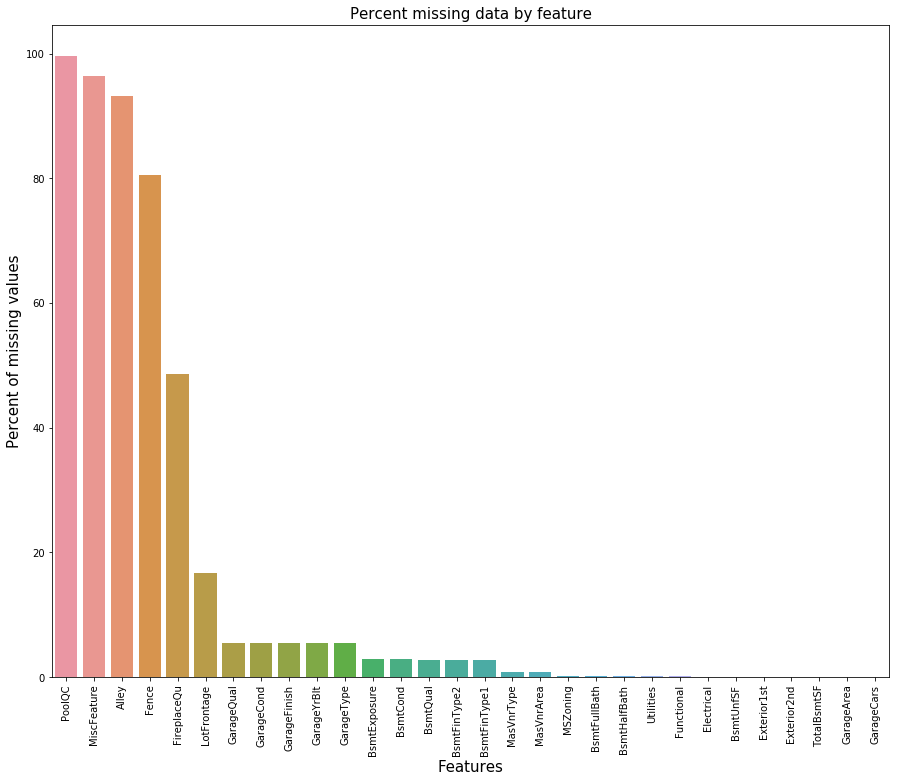

In [31]:
#将缺失度用图表的方式展示
f, ax = plt.subplots(figsize = (15,12))    #指定画布大小
plt.xticks(rotation = '90')    #定义x轴label显示旋转90度
sns.barplot(x = all_data_na.index,y = all_data_na)
plt.xlabel('Features',fontsize=15)
plt.ylabel('Percent of missing values',fontsize = 15)
plt.title('Percent missing data by feature',fontsize=15)

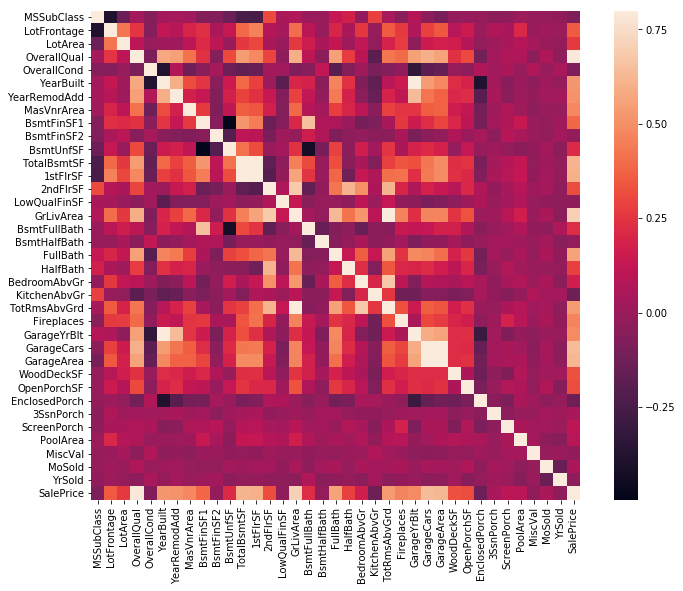

In [39]:
corrmat = train.corr()   #计算相关性矩阵函数
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square= True)

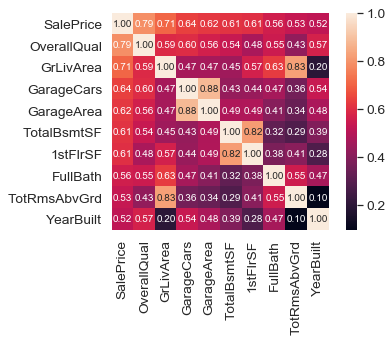

In [42]:
#选出10个与房价相关性最强的变量查看相关性系数

k = 10  #选择变量的个数
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale= 1.25)
hm = sns.heatmap(cm, cbar= True, annot= True, square= True,fmt= '.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

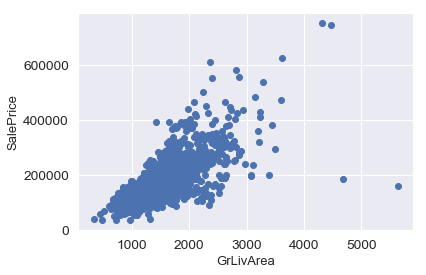

In [43]:
#GrLivArea代表含义是居住面积，发现和房价有比较明显的正相关关系
fig, ax = plt.subplots()
ax.scatter(x= train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show() 
#可以发现右下角有两个明显的离群值，考虑删除这两个异常值

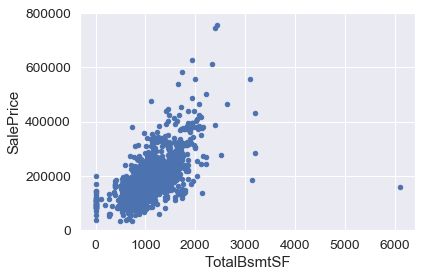

In [55]:
#TotalBsmtSF含义为地下室面积，发现地下室面积与房价似乎有更强的潜在线性关系，同时在右侧似乎也有一个异常值存在
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'],train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

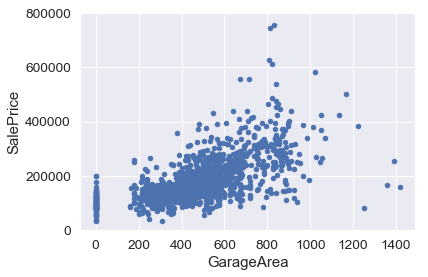

In [56]:
##GarageArea含义为车库面积，可看出车库面积和房价也存在一定的正相关关系
var= 'GarageArea'
data = pd.concat([train['SalePrice'],train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

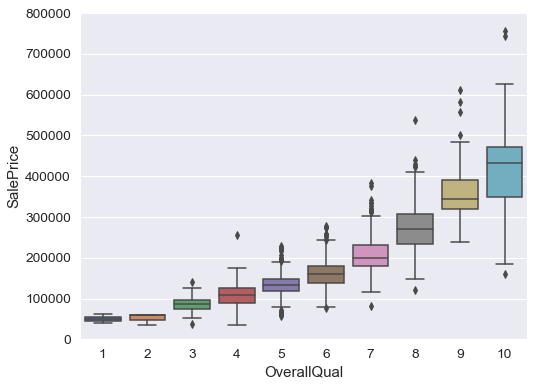

In [64]:
# 用箱线图离散变量查看 房屋质量和房价之间的关系，可以看到随着房屋整体质量的变好，房屋的整体价格也在逐渐提高
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize = (8,6))
fig = sns.boxplot(x= var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax = 800000);

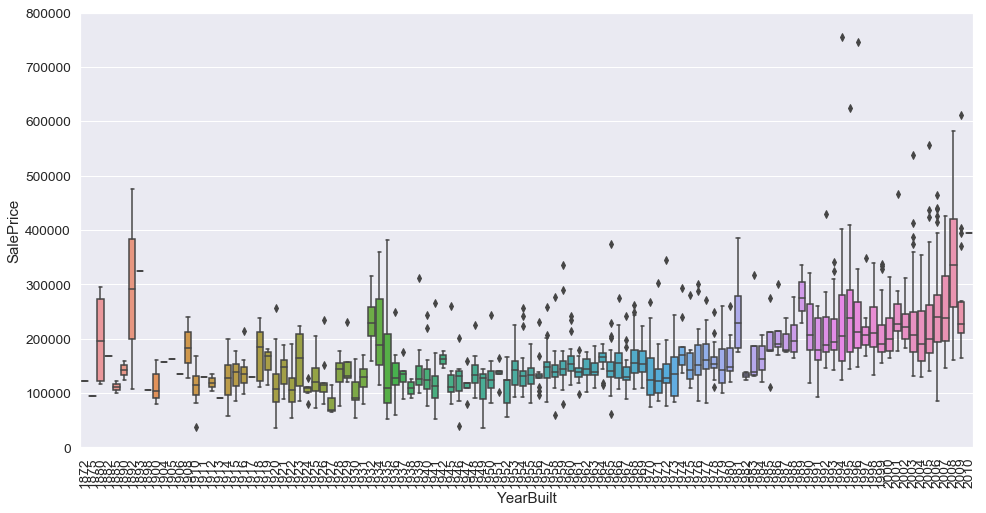

In [68]:
#房屋的建造时间和价格的关系，房屋的建造时间虽然没有和房价有明显的线性关系，但最近建造的新房屋，整体的价格会比较高
var= 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f,ax= plt.subplots(figsize=(16,8))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

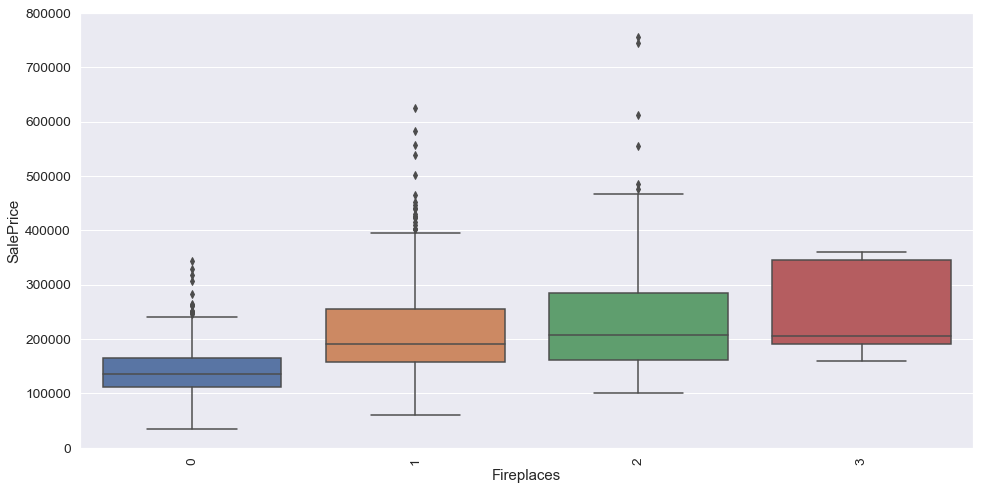

In [69]:
#再看一下壁炉数量和房价的关系，壁炉越多，房价越高
var= 'Fireplaces'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f,ax= plt.subplots(figsize=(16,8))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

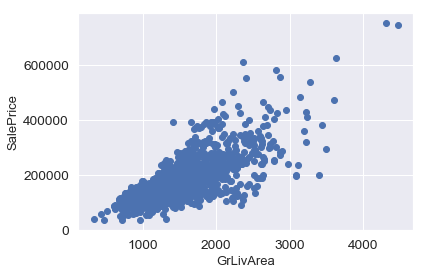

In [70]:
#数据处理: 删除异常值  重新画图
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

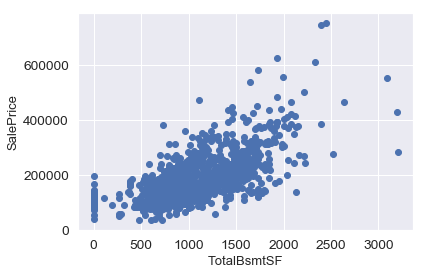

In [71]:
#地下室面积
train = train.drop(train[(train['TotalBsmtSF']>5000) & (train['SalePrice']<200000)].index)
fig, ax = plt.subplots()
ax.scatter(train['TotalBsmtSF'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

In [73]:
#缺失值处理： 先查看异常值分布情况
all_data_na = (all_data.isnull().sum()/ len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)[:30]
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data.head(50)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


In [74]:
all_data= all_data.drop('PoolQC',axis=1)
all_data= all_data.drop('MiscFeature',axis=1)
all_data= all_data.drop('Alley', axis=1)    #这几列缺失值都在90%以上 删掉

#数值缺失可能代表房屋没有这些东西 离散型变量用用None补充，连续型变量用0补充     
for col in ('Fence','FireplaceQu'):
    all_data[col]= all_data[col].fillna('None')                        #栅栏、壁炉

for col in ('GarageType','GarageFinish','GarageQual','GarageCond'):
    all_data[col]= all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)                            #车库相关     

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)                           #地下室相关
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")         
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)              #砖石结构相关

all_data['LotFrontage'] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))                       #LotFrontage：房屋前街道的长度，同一个街区房屋用均值填补

In [75]:
all_data.groupby('MSZoning')['MasVnrType'].count().reset_index()

,MSZoning,MasVnrType
0,C (all),25
1,FV,139
2,RH,26
3,RL,2265
4,RM,460


In [79]:
#MSZoning: 房屋所处的用地类型  用众数填补
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])  

all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [80]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio



 mu = 180932.92 and sigma = 79467.79



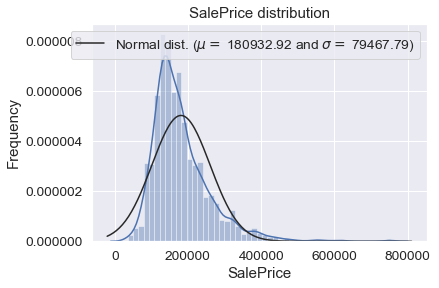

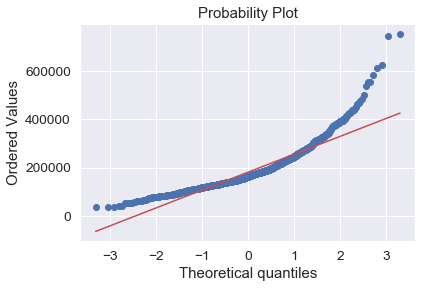

In [81]:
#用q-q plot 检测因变量是否符合正态分布 
sns.distplot(train['SalePrice'], fit= norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



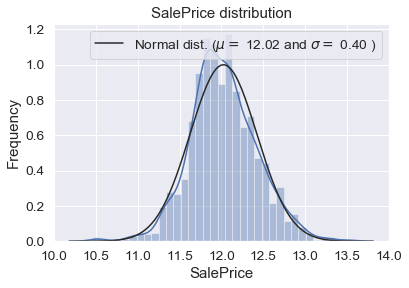

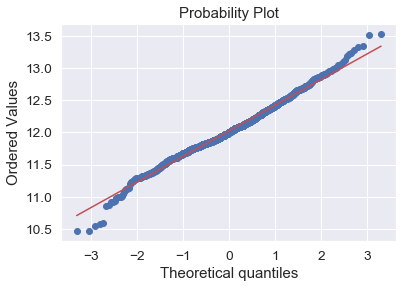

In [82]:
#对房价进行log对数变换
train['SalePrice'] = np.log1p(train['SalePrice'])

sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [83]:
#特征工程  
#创建新特征  房屋总面积和建造年份
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

all_data['YearBuilt_cut'] = all_data['YearBuilt'].apply(lambda x:1 if x>1990 else 0)

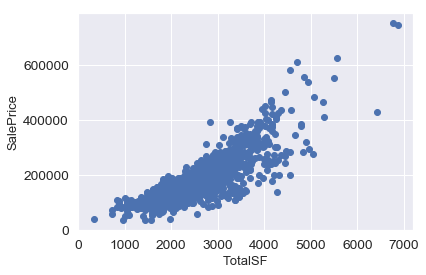

In [93]:
#验证下新特征与预测值的相关性
tep = all_data[:ntrain]
tep['SalePrice'] = y_train
tep = tep.drop(tep[(tep['TotalSF']>7800) & (tep['SalePrice']<200000)].index)

fig, ax = plt.subplots()
ax.scatter(tep['TotalSF'], tep['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalSF', fontsize=13)
plt.show()

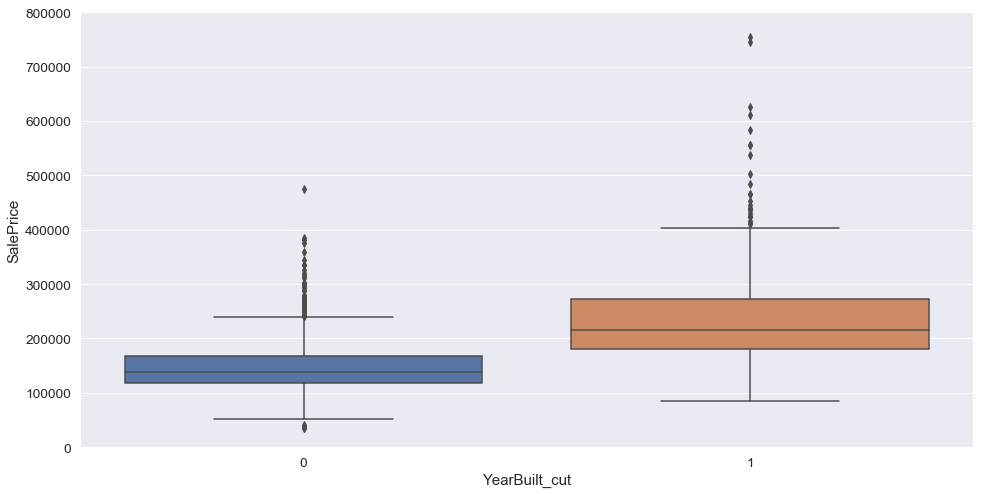

In [96]:
var = 'YearBuilt_cut'
data = pd.concat([tep['SalePrice'], tep[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x= var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000);

In [98]:
#对有序型离散变量 用label encoder编码
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

In [99]:
#非有序型变量编码 哑变量编码
all_data = pd.get_dummies(all_data)
all_data.shape

(2919, 219)

In [101]:
#特征筛选
threshold = 0.9 

#相关性矩阵
corr_matrix = all_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))  #选取矩阵的上三角
upper.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
1stFlrSF,NaN,0.249823,0.044086,0.108418,0.040297,0.247172,0.458206,0.084389,0.123944,0.024482,...,0.214149,0.005882,0.012406,0.000927,0.025617,0.001209,0.044160,0.214337,0.004251,0.163083
2ndFlrSF,NaN,NaN,0.032458,0.503506,0.016495,0.114369,0.161997,0.097654,0.158381,0.103646,...,0.012387,0.064275,0.004195,0.006715,0.030842,0.003710,0.003793,0.016457,0.038489,0.034428
3SsnPorch,NaN,NaN,NaN,0.048279,0.004530,0.007307,0.050934,0.023268,0.048451,0.000965,...,0.026513,0.000832,0.006639,0.004280,0.009796,0.005747,0.005417,0.027589,0.005066,0.014798
BedroomAbvGr,NaN,NaN,NaN,NaN,0.003379,0.116382,0.113161,0.031111,0.105416,0.047212,...,0.050701,0.014303,0.004409,0.033248,0.037084,0.039499,0.022958,0.043436,0.033877,0.047671
BsmtCond,NaN,NaN,NaN,NaN,NaN,0.103767,0.095140,0.003905,0.067643,0.072690,...,0.003567,0.015790,0.011458,0.013816,0.065433,0.006755,0.036183,0.006224,0.016353,0.025648


In [102]:
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
all_data = all_data.drop(columns = to_drop)
all_data.shape

(2919, 213)

In [103]:
#分开两个表
train = all_data[:ntrain]
test = all_data[ntrain:]      

0.05     33897.960487
0.10     33537.049027
0.30     32736.173326
1.00     32049.623131
3.00     31837.841618
5.00     31806.415070
10.00    31809.699270
15.00    31844.769400
30.00    31982.057442
50.00    32152.058382
75.00    32326.773039
dtype: float64

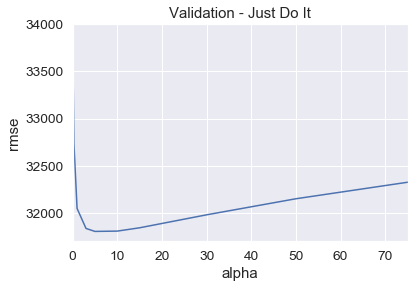

In [106]:
#建模
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

#进行交叉验证
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, train, y_train,scoring='neg_mean_squared_error', cv=5))
    return(rmse)
model_ridge = Ridge()  #导入ridge模型
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
           for alpha in alphas]
cv_ridge = pd.Series(cv_ridge,index= alphas)
cv_ridge.plot(title = 'Validation - Just Do It')
plt.xlabel('alpha')
plt.ylabel('rmse')     
cv_ridge               #由图看出alpha=5时模型误差最小

In [107]:
clf = Ridge(alpha=5)
clf.fit(train, y_train)
predict = clf.predict(test)   #进行预测

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = predict
sub.head(10)

,Id,SalePrice
0,1461,102481.075608
1,1462,148001.223102
2,1463,168658.731626
3,1464,175540.996322
4,1465,221122.057763
5,1466,167030.616336
6,1467,180802.584341
7,1468,157905.390491
8,1469,191970.570298
9,1470,122737.744521


In [109]:
sub.to_csv('submission.csv', index=False)